# Spectral fitting example (4C+21.35, flare)


**To run this, you need the following files, which can be downloaded using the first few cells of this notebook:**
- orientation file (COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori)       
- download unbinned data (COSI-SMEX/DC3/Data/Sources/4C21p35_flare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Sources/4C21p35_flare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Backgrounds/Ge/AlbedoPhotons_3months_unbinned_data_filtered_with_SAAcut.fits.gz), combine with background and binning     
- detector response (COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip)     

**The binned data are simulations of the 4C+21.35 (flare) and albedo photon background produced using the COSI SMEX mass model. The detector response needs to be unzipped before running the notebook.**

This notebook fits the spectrum of a 4C+21.35 (flare) simulated using MEGAlib and combined with background.

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple datasets from different instruments to be used coherently to fit the parameters of source model. A source model typically consists of a list of sources with parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the expected counts given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed up to a scaling factor. Finally, we will fit a Powerlaw function:

$$
f(x) = K \left(\frac{x}{E_{piv}}\right)^{\alpha}
$$

where $K$ (normalization), $\alpha$ (spectral index), are the free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = B*b_i + s_i(\mathbf{x})
$$

where $B*b_i$ are the estimated counts due to background in each bin with $B$ the amplitude and $b_i$ the shape of the background, and $s_i$ are the corresponding expected counts from the source, the goal is then to find the values of $\mathbf{x} = [K, \alpha]$ and $B$ that maximize $\mathcal{L}$. These are the best estimations of the parameters.

The final module needs to also fit the time-dependent background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [1]:
from cosipy import COSILike, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.util import fetch_wasabi_file

from scoords import SpacecraftFrame

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import poisson_conf_interval

import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

from threeML import Band, PointSource, Model, JointLikelihood, DataList
from cosipy import Band_Eflux
from astromodels import Parameter

from pathlib import Path

import os
import corner
from threeML import*
from astromodels import *


09:14:13 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=122423;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=932262;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#47\47]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=480071;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=730563;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#68\68]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=304581;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=840530;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=207742;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=328254;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=435692;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=621695;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=720136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=540921;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=430027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=522176;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

09:14:13 WARNING   ROOT minimizer not available                                                ]8;id=95093;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=368319;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=404589;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=428942;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=259782;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=129350;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=85596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=261703;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=639864;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=679957;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=836648;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=854866;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=265470;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=545414;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=678666;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=566084;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=987242;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=420947;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=286123;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=44716;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Get the data

Define the path to the directory to save the data. The data can be downloaded by running the cells below. Each respective cell also gives the wasabi file path and file size.

In [2]:
data_path = Path("/home/srinadb/cosipy/docs/tutorials/spectral_fits/dataset/")

Download the orientation file (684.38 MB)

In [3]:
fetch_wasabi_file('COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori', output=str(data_path /'DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori'))


{
    "AcceptRanges": "bytes",
    "LastModified": "Fri, 31 Jan 2025 16:35:35 GMT",
    "ContentLength": 79399708,
    "ETag": "\"e5e71e3528e39b855b0e4f74a1a2eebe\"",
    "ContentType": "application/octet-stream",
    "Metadata": {}
}


Download the response file (839.62 MB). This needs to be unzipped before running the rest of the notebook

In [4]:
fetch_wasabi_file('COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip', output=str(data_path / 'ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip'))


{
    "AcceptRanges": "bytes",
    "LastModified": "Thu, 20 Mar 2025 03:04:48 GMT",
    "ContentLength": 618765586,
    "ETag": "\"0233dfc01500b294b2bbd6d895692f48-7\"",
    "ContentType": "application/zip",
    "Metadata": {}
}


Read in the spacecraft orientation file

In [3]:
sc_orientation = SpacecraftFile.parse_from_file(data_path / "DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori")

Create BinnedData objects for the Crab only, Crab+background, and background only. The Crab only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [4]:
blazar = BinnedData("blazar.yaml")
blazar_bkg = BinnedData("blazar.yaml")
bkg = BinnedData("background.yaml")

Load binned .hdf5 files

In [5]:
blazar.load_binned_data_from_hdf5(binned_data="./4C21p35_flare_binned_data.hdf5")
blazar_bkg.load_binned_data_from_hdf5(binned_data="./4C21p35_flare_AlbedoPhoton_bkg_binned_data.hdf5")
bkg.load_binned_data_from_hdf5(binned_data="./AlbedoPhoton_bkg_binned_data.hdf5")

Define the path to the detector response

In [6]:
dr = str(data_path / "ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5") # path to detector response


## Perform spectral fit

Set background parameter, which is used to fit the amplitude of the background, and instantiate the COSI 3ML plugin

In [7]:
bkg_par = Parameter("background_cosi",                                         # background parameter
                     1,                                                        # initial value of parameter
                     min_value=0,                                              # minimum value of parameter
                     max_value=5,                                              # maximum value of parameter
                     delta=1e-3,                                               # initial step used by fitting engine
                     desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                        # COSI 3ML plugin
                 dr = dr,                                                      # detector response
                 data = blazar_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),   # data (source+background)
                 bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                 sc_orientation = sc_orientation,                              # spacecraft orientation
                 nuisance_param = bkg_par,                                     # background parameter
                 earth_occ = True)                                             # Option to account for Earth occultation

Define a point source at the known location with a Powerlaw function spectrum and add it to the model. The initial values of the Powerlaw function parameters are set close to the true values used to simulate the source.

In [8]:
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC3/sources/Extragalactic/4C21p35_noflare/4C21p35_noflare.source

l = 255.073637
b = 81.659766

index = -2.5
piv = 1e6 * u.keV
K = 1.52e-10 / u.cm / u.cm / u.s / u.keV 

spectrum = Powerlaw()

spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value

spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

source = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

# Optional: free the position parameters
#source.position.l.free = True
#source.position.b.free = True

model = Model(source)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

Gather all plugins and combine with the model in a JointLikelihood object, then perform maximum likelihood fit

In [9]:
import warnings
warnings.filterwarnings('ignore')

plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = True)

like.fit()

09:16:08 INFO      set the minimizer to minuit                                             ]8;id=235067;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=991777;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


         INFO      trial values: -9.8182,-2.5,1 -> logL = -5833080928.016                  ]8;id=706439;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=371244;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.6221,-2.5,1 -> logL = -9296081897.560                  ]8;id=783048;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=103845;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.015,-2.5,1 -> logL = -3627983895.720                  ]8;id=475279;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=589777;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.7985,-2.5,1 -> logL = -6113471135.577                  ]8;id=250440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=736823;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8378,-2.5,1 -> logL = -5565066813.788                  ]8;id=643503;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=113696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:09 INFO      trial values: -9.8182,-2.45,1 -> logL = -3803650716.557                 ]8;id=981655;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=826895;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.55,1 -> logL = -8894826075.119                 ]8;id=33254;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=263411;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.495,1 -> logL = -5590570641.745                ]8;id=393466;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=862094;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.505,1 -> logL = -6085771601.583                ]8;id=758592;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851603;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.5,1.0201 -> logL = -5833654511.952             ]8;id=88061;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485758;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.5,0.98007 -> logL = -5832511711.099            ]8;id=72689;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=458142;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.255,-2.3782,0.17946 -> logL = -602068903.968          ]8;id=792240;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=576476;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.201,-2.3932,0.060275 -> logL = -823458183.281         ]8;id=464850;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=7994;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.328,-2.3577,0.43795 -> logL = -380623073.681          ]8;id=473749;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=653870;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.467,-2.319,1.1831 -> logL = -133194483.598            ]8;id=279746;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=322490;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.552,-2.2955,1.7542 -> logL = -52438828.729            ]8;id=819717;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=813914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:10 INFO      trial values: -10.64,-2.2709,2.3982 -> logL = -2217899.236              ]8;id=92781;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12861;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.724,-2.2476,3.0197 -> logL = 24604395.673             ]8;id=756020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=722717;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.791,-2.2288,3.4972 -> logL = 36493694.831             ]8;id=303396;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=983036;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42368876.025             ]8;id=681418;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=16672;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.849,-2.2122,3.8858 -> logL = 42147091.962             ]8;id=385435;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12043;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.853,-2.2122,3.8858 -> logL = 42589592.832             ]8;id=891161;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=346137;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42338425.087             ]8;id=401622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=411541;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42399306.761             ]8;id=257862;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=397391;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2117,3.8858 -> logL = 42564433.125             ]8;id=992764;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=88974;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2127,3.8858 -> logL = 42172473.483             ]8;id=668180;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850021;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2121,3.8858 -> logL = 42399161.308             ]8;id=67067;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=230587;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:11 INFO      trial values: -10.851,-2.2123,3.8858 -> logL = 42338570.539             ]8;id=664577;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=144360;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8837 -> logL = 42418580.881             ]8;id=144596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223228;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8879 -> logL = 42319198.642             ]8;id=598445;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=803808;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.858,-2.2102,1.2092 -> logL = 99405617.187             ]8;id=347413;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=906607;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.887,-2.2023,4.8481 -> logL = 26219732.669             ]8;id=611856;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=807154;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36311 -> logL = 108142521.850           ]8;id=448521;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=205932;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.864,-2.2085,0.00688 -> logL = 99817314.193            ]8;id=165109;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=571659;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.904,-2.1975,0.0094791 -> logL = 103567914.361         ]8;id=969546;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=735979;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.885,-2.2028,4.9967 -> logL = 22163029.265             ]8;id=998283;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=727259;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.877,-2.2051,3.2349 -> logL = 62804679.139             ]8;id=973485;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=142989;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:12 INFO      trial values: -10.872,-2.2063,1.6115 -> logL = 95498565.010             ]8;id=46731;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882762;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.87,-2.2068,0.90054 -> logL = 105610257.063            ]8;id=431161;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438972;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.865,-2.2084,0.00039171 -> logL = 99374344.755         ]8;id=948679;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=617372;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.866,-2.2079,0.08662 -> logL = 103882498.489           ]8;id=768281;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=290973;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36311 -> logL = 108109509.728           ]8;id=398980;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=807603;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.869,-2.2074,0.36311 -> logL = 108175487.909           ]8;id=501846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=356931;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2073,0.36311 -> logL = 108176510.921           ]8;id=941808;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=451207;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2076,0.36311 -> logL = 108108485.889           ]8;id=914797;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=473979;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36489 -> logL = 108148380.355           ]8;id=417645;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=214831;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36133 -> logL = 108136514.219           ]8;id=89144;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=279119;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36416 -> logL = 108145984.952           ]8;id=534185;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=234576;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:13 INFO      trial values: -10.868,-2.2074,0.36207 -> logL = 108139007.181           ]8;id=408932;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=356771;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.876,-2.2053,0.84977 -> logL = 107062211.520           ]8;id=36172;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=606863;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51197 -> logL = 108569151.207           ]8;id=643528;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=822852;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.87,-2.2067,0.51197 -> logL = 108532761.903            ]8;id=680678;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=13143;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51197 -> logL = 108605489.569           ]8;id=726696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=427472;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2066,0.51197 -> logL = 108605970.267           ]8;id=48440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=656145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2068,0.51197 -> logL = 108532281.269           ]8;id=539877;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=392233;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51319 -> logL = 108565928.047           ]8;id=763821;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=571635;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51074 -> logL = 108572322.053           ]8;id=602912;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=419624;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.877,-2.205,0.51685 -> logL = 109492857.593            ]8;id=691082;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=520536;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.901,-2.1982,0.53661 -> logL = 112881380.104           ]8;id=933210;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=259542;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:14 INFO      trial values: -10.962,-2.1813,0.58741 -> logL = 119522368.114           ]8;id=840266;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=93377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.086,-2.1468,0.69711 -> logL = 127433242.157           ]8;id=771007;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=407742;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.153,-2.1279,0.76031 -> logL = 129756204.499           ]8;id=747477;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=457382;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.231,-2.1062,0.83559 -> logL = 131396237.050           ]8;id=634136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=371994;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.308,-2.0846,0.91332 -> logL = 132312923.396           ]8;id=920053;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=119892;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.369,-2.0677,0.97613 -> logL = 132693580.120           ]8;id=394711;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=13571;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0262 -> logL = 132837766.972            ]8;id=157800;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=466968;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0262 -> logL = 132836326.366            ]8;id=249455;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=164081;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.417,-2.0545,1.0262 -> logL = 132839204.803            ]8;id=536540;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582581;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.414,-2.0545,1.0262 -> logL = 132830860.087            ]8;id=532745;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=923884;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:15 INFO      trial values: -11.419,-2.0545,1.0262 -> logL = 132844610.514            ]8;id=408311;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=578659;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0543,1.0262 -> logL = 132839213.781            ]8;id=472486;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=737526;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0546,1.0262 -> logL = 132836317.349            ]8;id=52788;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=531487;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0538,1.0262 -> logL = 132844605.441            ]8;id=513690;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=972066;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0552,1.0262 -> logL = 132830865.161            ]8;id=43646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=606046;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.028 -> logL = 132831509.917             ]8;id=885066;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=373191;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0244 -> logL = 132843944.076            ]8;id=343458;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212466;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.425,-2.0522,0.86127 -> logL = 133081641.534           ]8;id=105117;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=247920;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0526,0.8917 -> logL = 133097872.672            ]8;id=833416;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=543409;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.421,-2.0526,0.8917 -> logL = 133093203.802            ]8;id=328608;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=318751;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.426,-2.0526,0.8917 -> logL = 133102487.258            ]8;id=771628;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=677414;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:16 INFO      trial values: -11.423,-2.0519,0.8917 -> logL = 133102608.384            ]8;id=743836;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=437765;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0533,0.8917 -> logL = 133093081.537            ]8;id=650293;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0526,0.89321 -> logL = 133098188.099           ]8;id=304106;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=663558;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0526,0.89018 -> logL = 133097486.976           ]8;id=894764;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=146949;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.437,-2.0488,0.89909 -> logL = 133148527.466           ]8;id=958819;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=604201;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.492,-2.0335,0.92889 -> logL = 133301997.644           ]8;id=968015;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=194535;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.571,-2.0113,0.97282 -> logL = 133419685.205           ]8;id=209745;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=37907;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.607,-2.0014,0.99264 -> logL = 133442475.996           ]8;id=961217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=183692;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.0075 -> logL = 133449777.157             ]8;id=462211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=918323;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.631,-1.994,1.0075 -> logL = 133448573.463             ]8;id=147490;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=948963;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:17 INFO      trial values: -11.636,-1.994,1.0075 -> logL = 133450966.269             ]8;id=474904;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438416;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.628,-1.994,1.0075 -> logL = 133447245.913             ]8;id=933693;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=457384;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.639,-1.994,1.0075 -> logL = 133452244.765             ]8;id=688738;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=405520;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9933,1.0075 -> logL = 133450953.206            ]8;id=395250;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=399846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9948,1.0075 -> logL = 133448586.746            ]8;id=836776;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=709957;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9925,1.0075 -> logL = 133452236.119            ]8;id=789040;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=781611;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9956,1.0075 -> logL = 133447254.559            ]8;id=636780;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=736733;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.009 -> logL = 133447717.743              ]8;id=399841;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=236490;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.006 -> logL = 133451773.438              ]8;id=621670;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=951885;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.663,-1.9859,0.97101 -> logL = 133497368.130           ]8;id=491255;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=75109;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95816 -> logL = 133501004.625           ]8;id=559011;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=509678;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:18 INFO      trial values: -11.667,-1.9829,0.95816 -> logL = 133499961.493           ]8;id=845443;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=38930;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.679,-1.9829,0.95816 -> logL = 133502009.058           ]8;id=197211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=876202;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9814,0.95816 -> logL = 133502040.268           ]8;id=794202;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=207065;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9845,0.95816 -> logL = 133499929.413           ]8;id=861688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=265206;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95965 -> logL = 133501397.016           ]8;id=127461;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=597506;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95667 -> logL = 133500545.307           ]8;id=898231;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=211739;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.708,-1.9732,0.96867 -> logL = 133514311.126           ]8;id=941064;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=806291;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.78,-1.9531,0.99054 -> logL = 133528167.088            ]8;id=442775;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=316221;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.798,-1.948,0.99609 -> logL = 133529237.094            ]8;id=96460;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=877059;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,0.99939 -> logL = 133529456.225            ]8;id=927426;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=244108;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:19 INFO      trial values: -11.802,-1.945,0.99939 -> logL = 133528982.300            ]8;id=778418;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=742029;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.817,-1.945,0.99939 -> logL = 133529908.774            ]8;id=607341;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=202201;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.797,-1.945,0.99939 -> logL = 133528624.454            ]8;id=96432;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=216213;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.822,-1.945,0.99939 -> logL = 133530224.312            ]8;id=843809;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=997924;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.943,0.99939 -> logL = 133529899.886            ]8;id=481337;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=861393;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.947,0.99939 -> logL = 133528991.683            ]8;id=92067;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=267820;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.9415,0.99939 -> logL = 133530217.792           ]8;id=879298;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=145656;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.9485,0.99939 -> logL = 133528630.973           ]8;id=985380;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588853;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,1.0009 -> logL = 133528838.040             ]8;id=991287;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=558832;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,0.99791 -> logL = 133530011.206            ]8;id=642995;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=631016;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.835,-1.938,0.99173 -> logL = 133533848.905            ]8;id=728069;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=684844;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:20 INFO      trial values: -11.851,-1.9332,0.98661 -> logL = 133534803.142           ]8;id=516177;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=749821;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.839,-1.9332,0.98661 -> logL = 133534540.881           ]8;id=825755;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=313377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.864,-1.9332,0.98661 -> logL = 133535028.783           ]8;id=403782;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=866344;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9298,0.98661 -> logL = 133535033.160           ]8;id=617436;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=868935;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9367,0.98661 -> logL = 133534536.066           ]8;id=163754;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=136499;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9332,0.98808 -> logL = 133534906.428           ]8;id=321099;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=887532;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9332,0.98513 -> logL = 133534635.119           ]8;id=325890;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=684494;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.88,-1.9252,0.99082 -> logL = 133536003.326            ]8;id=730378;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=948532;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.918,-1.9146,0.99632 -> logL = 133536701.905           ]8;id=201063;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=380434;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.926,-1.9124,0.9975 -> logL = 133536740.523            ]8;id=144261;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416550;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99808 -> logL = 133536746.241            ]8;id=190312;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=822199;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:21 INFO      trial values: -11.914,-1.9113,0.99808 -> logL = 133536629.797           ]8;id=386444;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=909522;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.947,-1.9113,0.99808 -> logL = 133536832.693           ]8;id=968301;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=540504;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.906,-1.9113,0.99808 -> logL = 133536565.760           ]8;id=337945;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=608774;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.954,-1.9113,0.99808 -> logL = 133536863.001           ]8;id=423520;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=608;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9067,0.99808 -> logL = 133536826.549            ]8;id=832809;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=199064;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9158,0.99808 -> logL = 133536636.570            ]8;id=988276;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=996820;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9045,0.99808 -> logL = 133536855.093            ]8;id=755182;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=487637;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.918,0.99808 -> logL = 133536573.665             ]8;id=535958;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=536875;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99955 -> logL = 133536598.154            ]8;id=720751;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=656583;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99661 -> logL = 133536830.716            ]8;id=770252;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=124628;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.941,-1.9084,0.99664 -> logL = 133536904.204           ]8;id=163156;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=700744;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:22 INFO      trial values: -11.946,-1.907,0.99596 -> logL = 133536924.883            ]8;id=937936;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=115413;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.922,-1.907,0.99596 -> logL = 133536869.389            ]8;id=512725;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=927171;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.97,-1.907,0.99596 -> logL = 133536929.776             ]8;id=130707;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=85309;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.9003,0.99596 -> logL = 133536924.035           ]8;id=409620;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=394020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.9137,0.99596 -> logL = 133536875.048           ]8;id=303508;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=618459;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.907,0.99742 -> logL = 133536908.085            ]8;id=30409;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=372418;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.907,0.99449 -> logL = 133536877.802            ]8;id=45764;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=467756;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.953,-1.9049,0.99661 -> logL = 133536940.104           ]8;id=485361;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=574583;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.956,-1.9041,0.99689 -> logL = 133536942.156           ]8;id=248190;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=356354;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99697 -> logL = 133536942.297           ]8;id=598375;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=910425;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:23 INFO      trial values: -11.93,-1.9038,0.99697 -> logL = 133536907.293            ]8;id=249100;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=443740;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.984,-1.9038,0.99697 -> logL = 133536921.077           ]8;id=157309;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=430962;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8963,0.99697 -> logL = 133536913.660           ]8;id=703376;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=598772;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9113,0.99697 -> logL = 133536914.929           ]8;id=21238;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=681082;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99844 -> logL = 133536909.050           ]8;id=843411;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=228729;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99551 -> logL = 133536911.861           ]8;id=266463;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=813479;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.958,-1.9036,0.99699 -> logL = 133536942.294           ]8;id=585815;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=25776;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=142588;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=292021;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.9037,0.99698 -> logL = 133536904.544           ]8;id=529283;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=692451;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.986,-1.9037,0.99698 -> logL = 133536916.689           ]8;id=690458;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=90744;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8957,0.99698 -> logL = 133536908.685           ]8;id=180389;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=385078;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:24 INFO      trial values: -11.957,-1.9117,0.99698 -> logL = 133536912.552           ]8;id=280891;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=337700;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99844 -> logL = 133536909.684           ]8;id=762598;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=339369;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99551 -> logL = 133536911.267           ]8;id=146452;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=153377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.958,-1.9035,0.997 -> logL = 133536942.257             ]8;id=645802;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=360142;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.958,-1.9037,0.99698 -> logL = 133536942.308           ]8;id=780612;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=543817;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.313           ]8;id=686794;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=763512;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=734032;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=423569;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=875470;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=760108;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=456089;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=630335;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=775266;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=541620;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=153086;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=830712;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:25 INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=50239;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=190372;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=310764;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=693916;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=592581;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=816018;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=480483;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=178919;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.9037,0.99698 -> logL = 133536904.544           ]8;id=256721;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=323387;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.986,-1.9037,0.99698 -> logL = 133536916.689           ]8;id=133896;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=633841;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8957,0.99698 -> logL = 133536908.685           ]8;id=824587;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=880929;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9117,0.99698 -> logL = 133536912.552           ]8;id=289923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=442770;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99844 -> logL = 133536909.684           ]8;id=644885;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=342110;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99551 -> logL = 133536911.267           ]8;id=481069;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=204882;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.952,-1.9037,0.99698 -> logL = 133536940.213           ]8;id=38695;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=730919;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:26 INFO      trial values: -11.963,-1.9037,0.99698 -> logL = 133536941.885           ]8;id=63032;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=989013;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.956,-1.9037,0.99698 -> logL = 133536942.099           ]8;id=388241;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=785163;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.959,-1.9037,0.99698 -> logL = 133536942.428           ]8;id=85086;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=798074;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9021,0.99698 -> logL = 133536940.276           ]8;id=66248;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=706575;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9053,0.99698 -> logL = 133536941.823           ]8;id=745688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=678982;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9034,0.99698 -> logL = 133536942.106           ]8;id=416647;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=322572;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.904,0.99698 -> logL = 133536942.421            ]8;id=40473;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=675621;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99727 -> logL = 133536940.880           ]8;id=741294;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=146750;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99669 -> logL = 133536941.201           ]8;id=544653;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=610038;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.8957,0.99698 -> logL = 133536934.131           ]8;id=818863;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=808397;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:27 INFO      trial values: -11.929,-1.9037,0.99844 -> logL = 133536836.102           ]8;id=225861;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=548217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8957,0.99844 -> logL = 133536908.185           ]8;id=988362;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=955422;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -16.169,-3.0194,1.0141 -> logL = 133534918.498            ]8;id=529187;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=122758;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,1.0001 -> logL = 133537050.894            ]8;id=221818;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=480320;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.709,-2.1081,1.0001 -> logL = 133537042.927            ]8;id=885370;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=994910;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.732,-2.1081,1.0001 -> logL = 133537049.764            ]8;id=44829;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=563934;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1049,1.0001 -> logL = 133537047.614            ]8;id=211025;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=536015;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1113,1.0001 -> logL = 133537044.922            ]8;id=152708;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=407459;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,1.0015 -> logL = 133536956.573            ]8;id=364659;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=325792;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,0.9986 -> logL = 133537081.538            ]8;id=295706;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=777308;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.041,-2.1981,0.99953 -> logL = 133537110.068           ]8;id=383067;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=177730;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:28 INFO      trial values: -13.327,-2.278,0.99905 -> logL = 133537127.803            ]8;id=300890;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=475533;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.296,-2.278,0.99905 -> logL = 133537076.096            ]8;id=496025;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=594744;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.357,-2.278,0.99905 -> logL = 133537111.115            ]8;id=757255;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=874132;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.2697,0.99905 -> logL = 133537110.129           ]8;id=429881;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=47920;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.2864,0.99905 -> logL = 133537075.789           ]8;id=626554;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=936423;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.278,1.0005 -> logL = 133537094.476             ]8;id=466516;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=569456;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.278,0.99758 -> logL = 133537097.357            ]8;id=471443;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=966484;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.44,-2.3062,0.99936 -> logL = 133537131.451            ]8;id=54218;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=808912;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.447,-2.3081,0.99938 -> logL = 133537131.509           ]8;id=896;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=44072;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,0.99942 -> logL = 133537131.560           ]8;id=208541;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=184585;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.433,-2.3119,0.99942 -> logL = 133537101.904           ]8;id=880860;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=553112;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:29 INFO      trial values: -13.492,-2.3119,0.99942 -> logL = 133537101.732           ]8;id=331926;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=301677;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.304,0.99942 -> logL = 133537101.459            ]8;id=638976;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=614174;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3199,0.99942 -> logL = 133537102.042           ]8;id=981545;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=996411;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,1.0009 -> logL = 133537099.379            ]8;id=574836;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=155147;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,0.99796 -> logL = 133537100.046           ]8;id=859034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=671468;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3252,0.99949 -> logL = 133537131.703           ]8;id=70158;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=672029;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.3237,0.99948 -> logL = 133537131.702           ]8;id=11172;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=566071;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.481,-2.3252,0.99949 -> logL = 133537099.871           ]8;id=941074;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=231598;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.542,-2.3252,0.99949 -> logL = 133537100.033           ]8;id=895051;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=799629;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3169,0.99949 -> logL = 133537099.975           ]8;id=652332;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=930680;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3334,0.99949 -> logL = 133537099.865           ]8;id=829419;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=735597;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:30 INFO      trial values: -13.512,-2.3252,1.001 -> logL = 133537099.593             ]8;id=219057;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=340488;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3252,0.99802 -> logL = 133537100.134           ]8;id=880968;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=628315;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3265,0.99949 -> logL = 133537131.702           ]8;id=429778;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=791963;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3257,0.99949 -> logL = 133537131.703           ]8;id=52252;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=46433;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=242663;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=919629;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3256,0.99949 -> logL = 133537099.812           ]8;id=177033;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=704914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.544,-2.3256,0.99949 -> logL = 133537099.925           ]8;id=516557;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=922102;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3173,0.99949 -> logL = 133537099.904           ]8;id=706674;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=863141;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3338,0.99949 -> logL = 133537099.831           ]8;id=645874;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=760451;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,1.001 -> logL = 133537099.678             ]8;id=763914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=896759;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99802 -> logL = 133537100.052           ]8;id=540888;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=343758;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:31 INFO      trial values: -13.52,-2.3272,0.99949 -> logL = 133537131.699            ]8;id=278431;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=183475;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.515,-2.326,0.99949 -> logL = 133537131.702            ]8;id=6036;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=633337;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3257,0.99949 -> logL = 133537131.703           ]8;id=328091;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=687039;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=146133;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=618100;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=692302;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=243822;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=83061;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=813403;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=67018;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=943812;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=280377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=986236;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=828255;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=947502;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=415974;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=936597;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=738517;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=720970;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:32 INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=64367;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=335980;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3256,0.99949 -> logL = 133537099.812           ]8;id=420154;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=498670;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.544,-2.3256,0.99949 -> logL = 133537099.925           ]8;id=410123;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=153989;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3173,0.99949 -> logL = 133537099.904           ]8;id=31804;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=428715;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3338,0.99949 -> logL = 133537099.831           ]8;id=303232;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=494684;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,1.001 -> logL = 133537099.678             ]8;id=487460;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=649647;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99802 -> logL = 133537100.052           ]8;id=367059;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=150806;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.507,-2.3256,0.99949 -> logL = 133537130.825           ]8;id=244979;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=250979;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.519,-2.3256,0.99949 -> logL = 133537130.040           ]8;id=493679;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=355669;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3256,0.99949 -> logL = 133537131.734           ]8;id=875524;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=898787;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:33 INFO      trial values: -13.515,-2.3256,0.99949 -> logL = 133537131.570           ]8;id=689497;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=467825;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3239,0.99949 -> logL = 133537130.036           ]8;id=109099;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=992037;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3272,0.99949 -> logL = 133537130.829           ]8;id=702648;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=859513;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3252,0.99949 -> logL = 133537131.570           ]8;id=350485;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=748853;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3259,0.99949 -> logL = 133537131.735           ]8;id=168119;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=128646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99978 -> logL = 133537130.389           ]8;id=421284;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=433181;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.9992 -> logL = 133537130.469            ]8;id=945920;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=936157;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99955 -> logL = 133537131.644           ]8;id=896854;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=45567;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99943 -> logL = 133537131.660           ]8;id=344109;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=179457;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3173,0.99949 -> logL = 133537131.607           ]8;id=871362;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=566279;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3256,1.001 -> logL = 133537037.601             ]8;id=716796;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=151607;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:34 INFO      trial values: -13.513,-2.3173,1.001 -> logL = 133537094.829             ]8;id=852342;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=745533;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=849021;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=5136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.456,-2.3256,0.99949 -> logL = 133537009.655           ]8;id=817455;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=656502;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3106,0.99949 -> logL = 133537034.780           ]8;id=316532;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=713760;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99976 -> logL = 133537130.608           ]8;id=265828;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=3891;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.57,-2.3156,0.99967 -> logL = 133536888.003            ]8;id=718877;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=319472;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.485,-2.3231,0.99953 -> logL = 133537119.108           ]8;id=262400;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=693061;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.494,-2.3389,0.9997 -> logL = 133536941.173            ]8;id=955208;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=44269;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.3176,0.99954 -> logL = 133537111.295           ]8;id=492334;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=152757;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.499,-2.3318,0.99964 -> logL = 133537078.324           ]8;id=619483;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=908380;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.3212,0.99957 -> logL = 133537128.656           ]8;id=812391;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=723457;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:35 INFO      trial values: -13.537,-2.3252,0.99967 -> logL = 133537111.750           ]8;id=315912;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=200958;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.498,-2.3236,0.99957 -> logL = 133537129.383           ]8;id=618046;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=327618;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3286,0.99964 -> logL = 133537123.526            ]8;id=243560;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=786576;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.507,-2.323,0.99959 -> logL = 133537131.159            ]8;id=547688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=917389;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.525,-2.3259,0.99965 -> logL = 133537128.181           ]8;id=61806;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=64880;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.505,-2.3242,0.99959 -> logL = 133537131.088           ]8;id=14132;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=50404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.503,-2.3229,0.99935 -> logL = 133537131.515           ]8;id=623046;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=541020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.511,-2.3236,0.99936 -> logL = 133537129.674           ]8;id=727551;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=894323;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.324,0.99953 -> logL = 133537131.646            ]8;id=189869;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=146696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3253,0.99933 -> logL = 133537131.471           ]8;id=268026;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=553824;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:36 INFO      trial values: -13.508,-2.3247,0.99939 -> logL = 133537131.704           ]8;id=834596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=4395;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.515,-2.3266,0.99959 -> logL = 133537131.388           ]8;id=725893;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=124673;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.3239,0.99941 -> logL = 133537131.703           ]8;id=971678;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=198741;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3254,0.99933 -> logL = 133537131.470           ]8;id=968058;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=360145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3244,0.99948 -> logL = 133537131.736           ]8;id=444541;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=832207;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3259,0.9995 -> logL = 133537131.712            ]8;id=988508;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=863553;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=734441;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=332410;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=943235;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=827652;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.325,0.99946 -> logL = 133537118.083            ]8;id=59560;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588395;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.529,-2.325,0.99946 -> logL = 133537120.261            ]8;id=207937;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=58192;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3194,0.99946 -> logL = 133537118.217            ]8;id=493739;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=754077;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:37 INFO      trial values: -13.51,-2.3306,0.99946 -> logL = 133537115.658            ]8;id=719783;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=18838;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99946 -> logL = 133537102.859            ]8;id=34960;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=300174;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3332,0.99946 -> logL = 133537096.868            ]8;id=865503;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=488322;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99983 -> logL = 133537129.535             ]8;id=217162;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=576013;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99909 -> logL = 133537129.843             ]8;id=435507;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=258416;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=798481;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=567074;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.325,0.99946 -> logL = 133537118.083            ]8;id=923709;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=948059;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.529,-2.325,0.99946 -> logL = 133537120.261            ]8;id=950164;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=904848;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99946 -> logL = 133537102.859            ]8;id=291417;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=992780;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3332,0.99946 -> logL = 133537096.868            ]8;id=564702;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=253910;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:38 INFO      trial values: -13.51,-2.325,0.99983 -> logL = 133537129.535             ]8;id=517097;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=974344;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99909 -> logL = 133537129.843             ]8;id=823268;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=225203;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.325,0.99946 -> logL = 133537131.122            ]8;id=420481;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=910787;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.325,0.99946 -> logL = 133537131.358            ]8;id=471085;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=331034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.325,0.99946 -> logL = 133537131.700            ]8;id=623968;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=291817;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.745             ]8;id=31914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=801695;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3234,0.99946 -> logL = 133537130.668            ]8;id=787273;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=37980;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3267,0.99946 -> logL = 133537130.273            ]8;id=43198;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=268118;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3247,0.99946 -> logL = 133537131.728            ]8;id=992224;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=70430;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3253,0.99946 -> logL = 133537131.655            ]8;id=186006;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=783575;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99946 -> logL = 133537131.748            ]8;id=504275;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=158682;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:39 INFO      trial values: -13.51,-2.3251,0.99946 -> logL = 133537131.733            ]8;id=46240;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=251369;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99953 -> logL = 133537131.630             ]8;id=81866;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=119837;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99938 -> logL = 133537131.691             ]8;id=484062;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=745206;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.3168,0.99946 -> logL = 133537127.746           ]8;id=802411;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=737705;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.325,0.99983 -> logL = 133537111.114            ]8;id=484634;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=587898;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99983 -> logL = 133537107.498            ]8;id=933511;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=436054;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=601847;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3249,0.99945 -> logL = 133537129.716           ]8;id=585418;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=874412;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3249,0.99945 -> logL = 133537129.774           ]8;id=351899;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=557892;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,0.99945 -> logL = 133537131.547            ]8;id=11072;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=671756;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3256,0.99945 -> logL = 133537131.546            ]8;id=206322;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=293020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:40 INFO      trial values: -13.51,-2.3249,1.0002 -> logL = 133537123.537             ]8;id=80324;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=827509;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99871 -> logL = 133537123.530            ]8;id=671148;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=85565;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3251,0.99945 -> logL = 133537131.749            ]8;id=557951;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=272506;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=631718;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=70375;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=570440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=253621;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=830538;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=744775;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=227982;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=19088;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=303258;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=541940;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=726622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=164585;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=3028;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=784284;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=896271;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=384059;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:41 INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=368115;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=900412;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=878893;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=731592;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=407662;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=345360;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3249,0.99945 -> logL = 133537129.716           ]8;id=877465;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=861334;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3249,0.99945 -> logL = 133537129.774           ]8;id=173121;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=976953;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,0.99945 -> logL = 133537131.547            ]8;id=132725;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=352955;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3256,0.99945 -> logL = 133537131.546            ]8;id=303317;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=679017;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,1.0002 -> logL = 133537123.537             ]8;id=413649;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=311112;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99871 -> logL = 133537123.530            ]8;id=947867;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=805211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3249,0.99945 -> logL = 133537131.670           ]8;id=167828;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=293310;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:42 INFO      trial values: -13.511,-2.3249,0.99945 -> logL = 133537131.669           ]8;id=60087;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=49016;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.3249,0.99945 -> logL = 133537131.746           ]8;id=619528;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=460119;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.746            ]8;id=326027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=827843;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=740527;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=108618;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=446103;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=911564;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3248,0.99945 -> logL = 133537131.741            ]8;id=22815;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=25077;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3251,0.99945 -> logL = 133537131.742            ]8;id=206377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=872034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=479496;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=821582;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=895987;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=355111;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.9996 -> logL = 133537131.421             ]8;id=777615;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=366118;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:43 INFO      trial values: -13.51,-2.3249,0.9993 -> logL = 133537131.420             ]8;id=139976;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=714190;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.736            ]8;id=945681;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=893012;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99942 -> logL = 133537131.736            ]8;id=91656;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=158382;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3243,0.99945 -> logL = 133537130.809           ]8;id=967240;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=81955;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3249,1.0002 -> logL = 133537117.744            ]8;id=530287;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=418013;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,1.0002 -> logL = 133537124.460             ]8;id=818640;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=180320;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=851026;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=641272;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=283770;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=955893;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=757219;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=621964;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=642915;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=547938;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=303807;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=743667;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

09:16:44 INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.736            ]8;id=776097;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=217585;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99942 -> logL = 133537131.736            ]8;id=811161;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=478167;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=593160;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129407;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=258961;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=326159;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=628780;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=704712;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=253519;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=650194;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99946 -> logL = 133537131.749            ]8;id=377696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=197649;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=874314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=586565;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=82822;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=521204;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.735            ]8;id=597910;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=718869;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.738            ]8;id=335481;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=439363;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=989702;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=511134;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(3.1 -0.5 +0.6) x 10^-14,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-2.325 +/- 0.022,
background_cosi,(9.9945 +/- 0.0023) x 10^-1,


Correlation matrix:

1.00,1.00,-0.49
1.00,1.00,-0.47
-0.49,-0.47,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.335371e+08
total,-1.335371e+08


Values of statistical measures:

,statistical measures
AIC,-2.670743e+08
BIC,-2.670743e+08


(                                            value  negative_error  \
 source.spectrum.main.Powerlaw.K      3.092102e-14   -5.302886e-15   
 source.spectrum.main.Powerlaw.index -2.324942e+00   -2.200058e-02   
 background_cosi                      9.994524e-01   -2.262668e-04   
 
                                      positive_error         error  \
 source.spectrum.main.Powerlaw.K        6.071914e-15  5.687400e-15   
 source.spectrum.main.Powerlaw.index    2.083984e-02  2.142021e-02   
 background_cosi                        2.348104e-04  2.305386e-04   
 
                                                 unit  
 source.spectrum.main.Powerlaw.K      1 / (keV s cm2)  
 source.spectrum.main.Powerlaw.index                   
 background_cosi                                       ,
        -log(likelihood)
 cosi      -1.335371e+08
 total     -1.335371e+08)

## Error propagation and plotting (Powerlaw function)

Define Powerlaw function spectrum injected into MEGAlib

In [10]:
index_inj = -2.5
K_inj = 2.596576815334794e-14 / u.cm / u.cm / u.s / u.keV # 1.049977250e-14
# K_inj = 1.049977250e-14 / u.cm / u.cm / u.s / u.keV # 1.049977250e-14
piv_inj = 1e6 * u.keV

spectrum_inj = Powerlaw()

spectrum_inj.index.value = index_inj
spectrum_inj.K.value = K_inj.value
spectrum_inj.piv.value = piv_inj.value

spectrum_inj.K.unit = K_inj.unit
spectrum_inj.piv.unit = piv_inj.unit


The summary of the results above tell you the optimal values of the parameters, as well as the errors. Propogate the errors to the "evaluate_at" method of the spectrum

In [11]:
results = like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(3.1 -0.5 +0.6) x 10^-14,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-2.325 +/- 0.022,
background_cosi,(9.9945 +/- 0.0023) x 10^-1,


Correlation matrix:

1.00,1.00,-0.49
1.00,1.00,-0.47
-0.49,-0.47,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.335371e+08
total,-1.335371e+08


Values of statistical measures:

,statistical measures
AIC,-2.670743e+08
BIC,-2.670743e+08


None
  * source (point source):
    * position:
      * l:
        * value: 255.073637
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: 81.659766
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Powerlaw:
          * K:
            * value: 3.092101652471777e-14
            * desc: Normalization (differential flux at the pivot value)
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * piv:
            * value: 1000000.0
            * desc: Pivot value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * index:
            * value: -2.3249419

In [12]:
print(max(results.samples[0]))
print(min(results.samples[0]))

5.852728449911103e-14
1.62662889828756e-14


A method for plotting corner plots for the spectral fitting parameters is added. This helps in understanding the correlation between/among parameters of the powerlaw function.

Evaluate the flux and errors at a range of energies for the fitted and injected spectra, and the simulated source flux

In [13]:
energy = np.geomspace(100*u.keV,10*u.MeV).to_value(u.keV)
# COSI_emin, COSI_emax = 0.2, 10 #MeV
# energy = np.logspace(np.log10(COSI_emin), np.log10(COSI_emax), 1000)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)
flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    flux_inj[i] = spectrum_inj.evaluate_at(e)
    
binned_energy_edges = blazar.binned_data.axes['Em'].edges.value
binned_energy = np.array([])
bin_sizes = np.array([])

for i in range(len(binned_energy_edges)-1):
    binned_energy = np.append(binned_energy, (binned_energy_edges[i+1] + binned_energy_edges[i]) / 2)
    bin_sizes = np.append(bin_sizes, binned_energy_edges[i+1] - binned_energy_edges[i])

expectation = cosi._expected_counts['source']

Plot the fitted and injected spectra

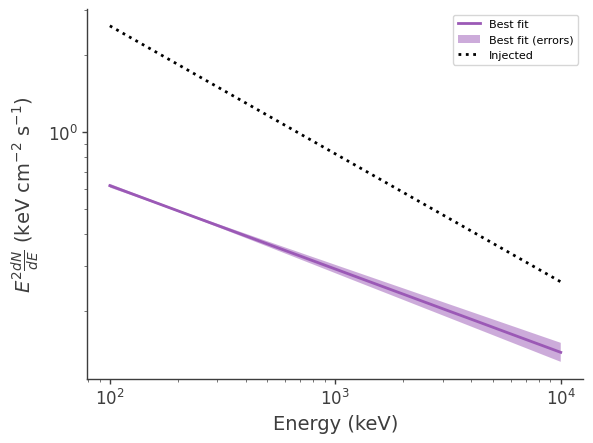

In [14]:
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Best fit")
ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Best fit (errors)")
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()
plt.show()
# fig.savefig('./Spectral_fitting_4cp2135_flare.png')
plt.close()

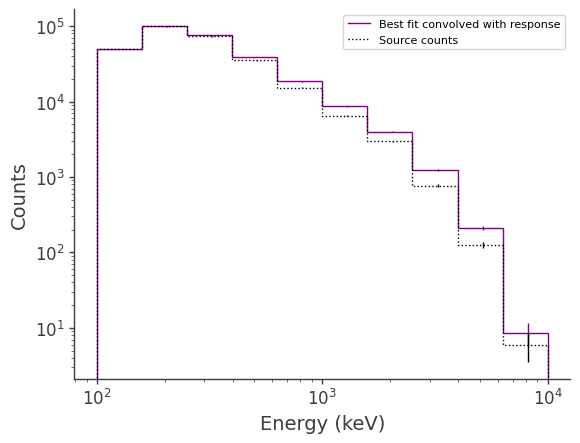

In [15]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents, yerr=np.sqrt(expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(blazar.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Source counts")
ax.errorbar(binned_energy, blazar.binned_data.project('Em').todense().contents, yerr=np.sqrt(blazar.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

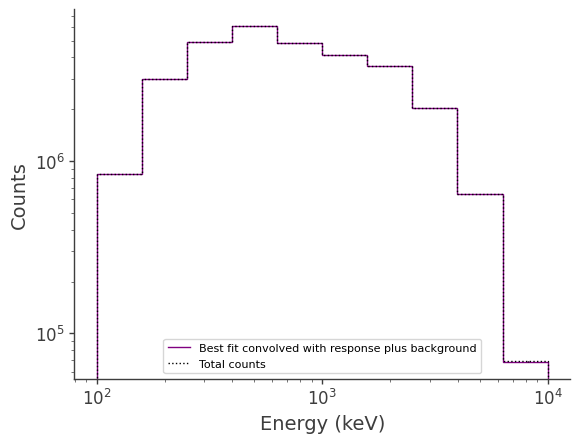

In [16]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), binned_energy_edges, color='purple', label = "Best fit convolved with response plus background")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), yerr=np.sqrt(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents)), color='purple', linewidth=0, elinewidth=1)
ax.stairs(blazar_bkg.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Total counts")
ax.errorbar(binned_energy, blazar_bkg.binned_data.project('Em').todense().contents, yerr=np.sqrt(blazar_bkg.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

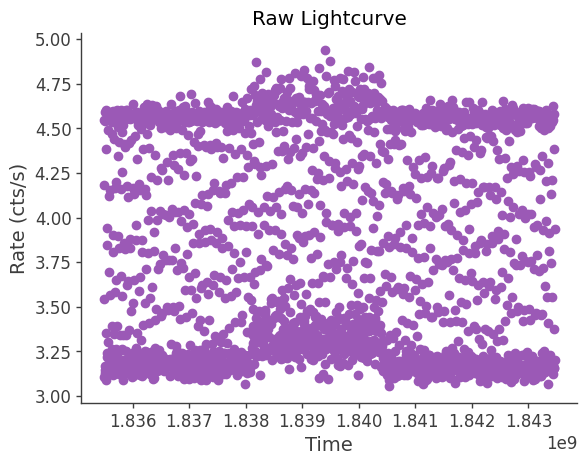

In [17]:
blazar_bkg.get_raw_lightcurve(binned_data="4C21p35_flare_AlbedoPhoton_bkg_binned_data.hdf5", output_name="lc_flare")
time, rate = np.loadtxt("lc_flare.dat", skiprows=1, unpack=True)
plt.scatter(time, rate)
plt.xlabel('Time')
plt.ylabel('Rate (cts/s)')
plt.title('Raw Lightcurve')
plt.savefig('./Raw_lc_4cp2135_flare.png', dpi=300)
plt.show()
plt.close()
plt.close()

Compute integral flux from the fitted spectrum

#### Method 1 from threeML without error propagation

In [18]:
simulated_flux = 0.017293201590129727


In [19]:
# https://threeml.readthedocs.io/en/latest/notebooks/flux_examples.html
# Get the simulated flux from the below
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/Galactic/Crab/Crab.source

threeML_config.point_source.integrate_flux_method = "quad" # trapz, quad
result_fl=results.get_flux(
        ene_min= 100. * u.keV,
        ene_max= 10000. * u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)" # 1/(cm2 s) (for integral photon flux) and keV/(cm2 s) or erg/(cm2 s) (for integral photon flux)
    )
print(result_fl)
# fl.flux.apply(lambda x: float(str(x).split()[1])).values[0]

print('\nThe simulated flux is: '+str(simulated_flux)+'\n')
print('Flux from the fitted spectrum (quad) is: '+str(result_fl["flux"].values[0].value)+'')

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

                                   flux                         low bound  \
total  0.004642942184146974 1 / (s cm2)  0.004553257090638516 1 / (s cm2)   

                               hi bound  
total  0.004736479527462134 1 / (s cm2)  

The simulated flux is: 0.017293201590129727

Flux from the fitted spectrum (quad) is: 0.004642942184146974


In [20]:
# https://threeml.readthedocs.io/en/latest/notebooks/flux_examples.html
# Get the simulated flux from the below
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/GRBs/GRB090206620/GRB090206620.source

threeML_config.point_source.integrate_flux_method = "trapz" # trapz, quad
result_fl=results.get_flux(
        ene_min= 100. * u.keV,
        ene_max= 10000. * u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)" # 1/(cm2 s) (for integral photon flux) and keV/(cm2 s) or erg/(cm2 s) (for integral photon flux)
    )
print(result_fl)
# fl.flux.apply(lambda x: float(str(x).split()[1])).values[0]

print('\nThe simulated flux is: '+str(simulated_flux)+'\n')
print('Flux from the fitted spectrum (trapz) is: '+str(result_fl["flux"].values[0].value)+'')

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

                                   flux                        low bound  \
total  0.007886759275562419 1 / (s cm2)  0.00770668484353281 1 / (s cm2)   

                               hi bound  
total  0.008073445751510994 1 / (s cm2)  

The simulated flux is: 0.017293201590129727

Flux from the fitted spectrum (trapz) is: 0.007886759275562419


#### Method 2 Manual Methods

In [21]:
bin_energy_edges = np.geomspace(blazar_bkg.binned_data.axes['Em'].edges[0],blazar_bkg.binned_data.axes['Em'].edges[-1], 51).to_value(u.keV)

bin_energy = np.array([])
bin_energy_delta = np.array([])

for i in range(len(bin_energy_edges)-1):
    bin_energy = np.append(bin_energy, np.sqrt(bin_energy_edges[i+1]*bin_energy_edges[i]))
    bin_energy_delta = np.append(bin_energy_delta, bin_energy_edges[i+1]-bin_energy_edges[i])

photon_flux = 0
energy_flux = 0
        
for i, e in enumerate(bin_energy):
    photon_flux += results_err(e)*bin_energy_delta[i]
    energy_flux += results_err(e)*e*bin_energy_delta[i]

print('Photon Flux from the fitted spectrum is: '+str(photon_flux.median)+'')
print('Energy Flux from the fitted spectrum is: '+str(energy_flux.median)+'')

Photon Flux from the fitted spectrum is: 0.0046416820838437265
Energy Flux from the fitted spectrum is: 1.4717551486472886


In [22]:
bin_energy_edges = np.geomspace(blazar_bkg.binned_data.axes['Em'].edges[0],blazar_bkg.binned_data.axes['Em'].edges[-1], 51).to_value(u.keV)

bin_energy = np.array([])
bin_energy_delta = np.array([])

for i in range(len(bin_energy_edges)-1):
    bin_energy = np.append(bin_energy, np.sqrt(bin_energy_edges[i+1]*bin_energy_edges[i]))
    bin_energy_delta = np.append(bin_energy_delta, bin_energy_edges[i+1]-bin_energy_edges[i])

photon_flux = 0
energy_flux = 0
        
for i, e in enumerate(bin_energy):
    photon_flux += spectrum(e)*bin_energy_delta[i]
    energy_flux += spectrum(e)*e*bin_energy_delta[i]

print('Photon Flux from the fitted spectrum is: '+str(photon_flux)+'')
print('Energy Flux from the fitted spectrum is: '+str(energy_flux)+'')

Photon Flux from the fitted spectrum is: 0.004642321867300481
Energy Flux from the fitted spectrum is: 1.4731702720535884


In [23]:
bin_energy_edges = np.geomspace(blazar_bkg.binned_data.axes['Em'].edges[0],blazar_bkg.binned_data.axes['Em'].edges[-1], 51).to_value(u.keV)

bin_energy = np.array([])
bin_energy_delta = np.array([])

for i in range(len(bin_energy_edges)-1):
    bin_energy = np.append(bin_energy, np.sqrt(bin_energy_edges[i+1]*bin_energy_edges[i]))
    bin_energy_delta = np.append(bin_energy_delta, bin_energy_edges[i+1]-bin_energy_edges[i])

photon_flux = 0
energy_flux = 0
        
for i, e in enumerate(bin_energy):
    photon_flux += spectrum_inj(e)*bin_energy_delta[i]
    energy_flux += spectrum_inj(e)*e*bin_energy_delta[i]

print('Photon Flux from the fitted spectrum is: '+str(photon_flux)+'')
print('Energy Flux from the fitted spectrum is: '+str(energy_flux)+'')

Photon Flux from the fitted spectrum is: 0.01728556446573996
Energy Flux from the fitted spectrum is: 4.675077333060157


In [24]:
flux_inj

array([2.59657682e-04, 2.05286485e-04, 1.62300382e-04, 1.28315383e-04,
       1.01446697e-04, 8.02041967e-05, 6.34097845e-05, 5.01320496e-05,
       3.96346150e-05, 3.13352979e-05, 2.47738219e-05, 1.95862907e-05,
       1.54850060e-05, 1.22425127e-05, 9.67898343e-06, 7.65224612e-06,
       6.04989885e-06, 4.78307617e-06, 3.78152069e-06, 2.98968660e-06,
       2.36365914e-06, 1.86871913e-06, 1.47741742e-06, 1.16805260e-06,
       9.23467431e-07, 7.30097341e-07, 5.77218113e-07, 4.56351134e-07,
       3.60793179e-07, 2.85244646e-07, 2.25515650e-07, 1.78293647e-07,
       1.40959728e-07, 1.11443370e-07, 8.81076098e-08, 6.96582570e-08,
       5.50721190e-08, 4.35402553e-08, 3.44231140e-08, 2.72150626e-08,
       2.15163461e-08, 1.70109162e-08, 1.34489039e-08, 1.06327615e-08,
       8.40630720e-09, 6.64606279e-09, 5.25440596e-09, 4.15415606e-09,
       3.28429373e-09, 2.59657682e-09])

In [25]:
spectrum_inj(energy)

array([2.59657682e-04, 2.05286485e-04, 1.62300382e-04, 1.28315383e-04,
       1.01446697e-04, 8.02041967e-05, 6.34097845e-05, 5.01320496e-05,
       3.96346150e-05, 3.13352979e-05, 2.47738219e-05, 1.95862907e-05,
       1.54850060e-05, 1.22425127e-05, 9.67898343e-06, 7.65224612e-06,
       6.04989885e-06, 4.78307617e-06, 3.78152069e-06, 2.98968660e-06,
       2.36365914e-06, 1.86871913e-06, 1.47741742e-06, 1.16805260e-06,
       9.23467431e-07, 7.30097341e-07, 5.77218113e-07, 4.56351134e-07,
       3.60793179e-07, 2.85244646e-07, 2.25515650e-07, 1.78293647e-07,
       1.40959728e-07, 1.11443370e-07, 8.81076098e-08, 6.96582570e-08,
       5.50721190e-08, 4.35402553e-08, 3.44231140e-08, 2.72150626e-08,
       2.15163461e-08, 1.70109162e-08, 1.34489039e-08, 1.06327615e-08,
       8.40630720e-09, 6.64606279e-09, 5.25440596e-09, 4.15415606e-09,
       3.28429373e-09, 2.59657682e-09])

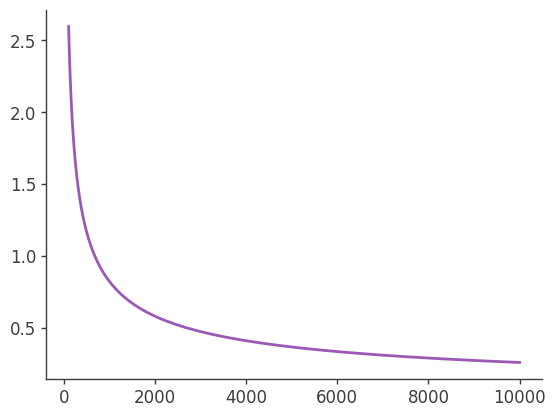

In [26]:
plt.plot(energy, energy*energy*spectrum_inj(energy))
ax.set_xscale("log")
ax.set_yscale("log")


In [27]:
spectrum_inj(energy)

array([2.59657682e-04, 2.05286485e-04, 1.62300382e-04, 1.28315383e-04,
       1.01446697e-04, 8.02041967e-05, 6.34097845e-05, 5.01320496e-05,
       3.96346150e-05, 3.13352979e-05, 2.47738219e-05, 1.95862907e-05,
       1.54850060e-05, 1.22425127e-05, 9.67898343e-06, 7.65224612e-06,
       6.04989885e-06, 4.78307617e-06, 3.78152069e-06, 2.98968660e-06,
       2.36365914e-06, 1.86871913e-06, 1.47741742e-06, 1.16805260e-06,
       9.23467431e-07, 7.30097341e-07, 5.77218113e-07, 4.56351134e-07,
       3.60793179e-07, 2.85244646e-07, 2.25515650e-07, 1.78293647e-07,
       1.40959728e-07, 1.11443370e-07, 8.81076098e-08, 6.96582570e-08,
       5.50721190e-08, 4.35402553e-08, 3.44231140e-08, 2.72150626e-08,
       2.15163461e-08, 1.70109162e-08, 1.34489039e-08, 1.06327615e-08,
       8.40630720e-09, 6.64606279e-09, 5.25440596e-09, 4.15415606e-09,
       3.28429373e-09, 2.59657682e-09])

In [28]:
spectrum_inj.evaluate_at(energy)

array([2.59657682e-04, 2.05286485e-04, 1.62300382e-04, 1.28315383e-04,
       1.01446697e-04, 8.02041967e-05, 6.34097845e-05, 5.01320496e-05,
       3.96346150e-05, 3.13352979e-05, 2.47738219e-05, 1.95862907e-05,
       1.54850060e-05, 1.22425127e-05, 9.67898343e-06, 7.65224612e-06,
       6.04989885e-06, 4.78307617e-06, 3.78152069e-06, 2.98968660e-06,
       2.36365914e-06, 1.86871913e-06, 1.47741742e-06, 1.16805260e-06,
       9.23467431e-07, 7.30097341e-07, 5.77218113e-07, 4.56351134e-07,
       3.60793179e-07, 2.85244646e-07, 2.25515650e-07, 1.78293647e-07,
       1.40959728e-07, 1.11443370e-07, 8.81076098e-08, 6.96582570e-08,
       5.50721190e-08, 4.35402553e-08, 3.44231140e-08, 2.72150626e-08,
       2.15163461e-08, 1.70109162e-08, 1.34489039e-08, 1.06327615e-08,
       8.40630720e-09, 6.64606279e-09, 5.25440596e-09, 4.15415606e-09,
       3.28429373e-09, 2.59657682e-09])

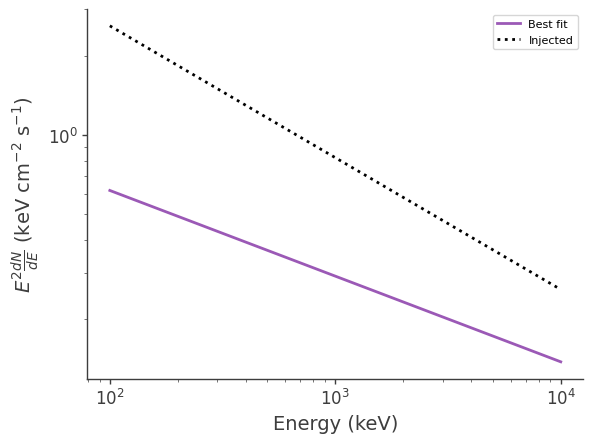

In [29]:
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*spectrum(energy), label = "Best fit")
ax.plot(energy, energy*energy*spectrum_inj(energy), color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()
plt.show()
# fig.savefig('./Spectral_fitting_4cp2135_flare.png')
plt.close()